# Time Series Forecasting in a Real Life Scenario

What we will learn from this notebook:
* What is a Time Series Data?
* Problem Statement
* Interpolation for Missing Values
* Exploratory Data Analysis
* Detailed Data Manipulation for Holidays and Events
* Visualizing Time Series Data
* ETS Decomposition
* White Noise
* Stationarity and Augmented Dicker-Fuller Test
* ACF & PACF
* EWMA
* Holt - Winters
* Model Selection with AIC (Akaike's Information Criterion)
* ARIMA
* SARIMA
* SARIMAX

## 1. What is a Time Series Data?

A time series is simply a series of data points ordered in time. In a time series, time is often the independent variable and the goal is usually to make a forecast for the future.

The famous airline passengers problem:
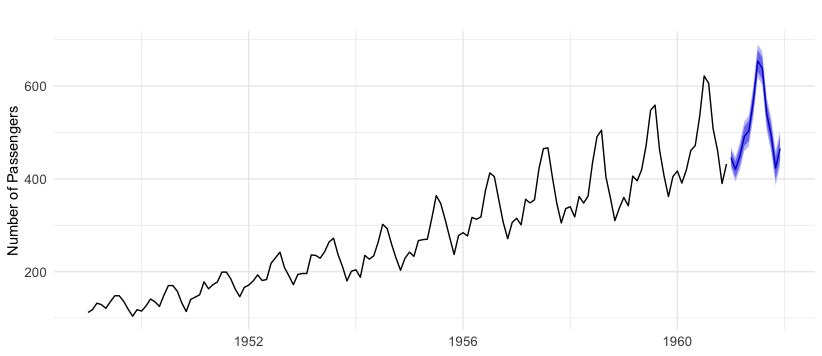



## Problem Statement

We need to build a time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.
Specifically we need to build a model that accurately predicts the unit sales for thousands of items sold at different Favorita stores. This will help to reduce the waste of products, increase profits and satisfy the clients with the products they need.


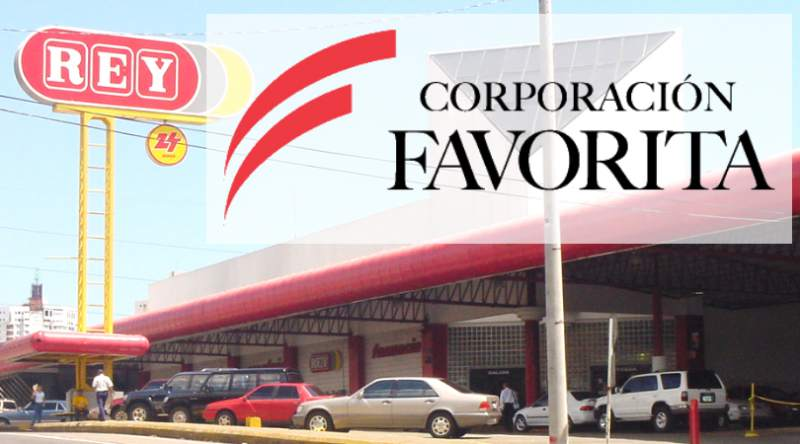

### Python Libraries

In [ ]:
#Base Libraries
import numpy as np
import pandas as pd
import os
import gc
import warnings

# PACF and ACF Library
import statsmodels.api as sm

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Configurations
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

### Importing data

In [ ]:
#Import
train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')
stores = pd.read_csv("../input/store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv').sort_values(["store_nbr","date"])

In [ ]:
# Datetime
train['date'] = pd.to_datetime(train.date)
test['date'] = pd.to_datetime(test.date)
transactions['date'] = pd.to_datetime(transactions.date)

In [ ]:
# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

In [ ]:
train.head()

## Interpolation for Missing Values

Interpolationa is a statistical method by which related known values are used to estimate an unknown price or potential yield of a security. Interpolation is achieved by using other established values that are located in sequence with the unknown value. 

As we know the economical factors are very important when we are talking about forecasting. Ecuardor is a very oil dependant country, changing oil prices in Ecuador will cause a strong variance in sales, because people would have a different amount of money to spend due to this factor.

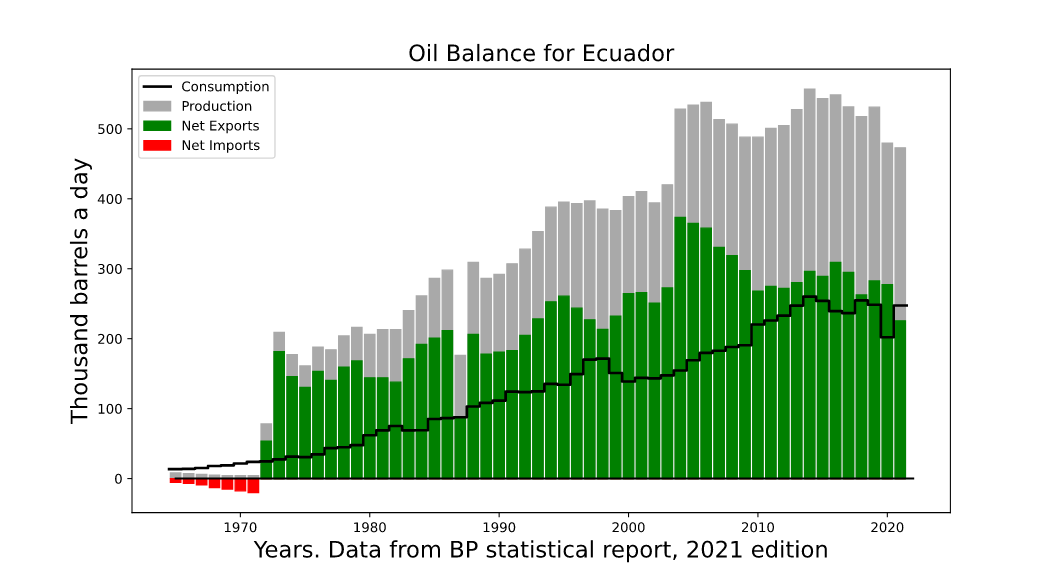

In [ ]:
oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv").sort_values(['date'])
oil["date"] = pd.to_datetime(oil.date)

In [ ]:
oil.head(5)

In [ ]:
# As we can see here we find
oil.info()

In [ ]:
# Date Index Oil
oil = oil.set_index("date")

In [ ]:
# Data Resampling, filling nulls and reseting index
oil = oil.dcoilwtico.resample("D").sum().reset_index()

In [ ]:
# Interpolate
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate()

In [ ]:
#Plot
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')
px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Daily Oil Price" )

## Exploratory Data Analysis

### Transactions

In [ ]:
transactions


It is believed that the transactions are highly correlated with the sales, in order to prove this it is necessary to first sum the sales by store and date.

In [ ]:
train_store = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()
train_store

In [ ]:
temp = train_store.merge(transactions,on=["date", "store_nbr"], how = "left")

In [ ]:
temp

In [ ]:
print('Spearman Correlation between Total Sales and Transactions: {:.4f}'.format(temp.corr("spearman").sales.loc["transactions"]))

In [ ]:
px.line(transactions.sort_values(["store_nbr","date"]),x="date",y="transactions",color="store_nbr", title="Transactions by store")

In [ ]:
a= transactions.copy()
a['year'] = a.date.dt.year
a['month'] = a.date.dt.month
px.box(a,x='year', y='transactions', color='month', title='Transactions per Month')

In [ ]:
b = transactions.set_index('date').resample('M').mean().reset_index().sort_values(['date'])
b['year'] =  b.date.dt.year
px.line(b, x='date', y='transactions', color='year', title='Transactions every year')

In [ ]:
px.scatter(temp, x='transactions', y='sales', trendline="ols", trendline_color_override='gold', title='Transaction & Sales')

In [ ]:
c= transactions.copy()
c['year'] = c.date.dt.year
c['dayofweek'] = c.date.dt.dayofweek+1
c = c.groupby(['year','dayofweek']).transactions.mean().reset_index()
px.line(c, x='dayofweek', y='transactions', color='year', title='Mean transactions per day of week')

### Oil Price

In [ ]:
oil

In [ ]:
temp_oil = temp.merge(oil,on=['date'], how='left')
temp_oil
print("Correlation with Daily Oil Prices")
print(temp_oil.corr("spearman").dcoilwtico_interpolated.iloc[1:3])


In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
temp_oil.plot.scatter(x="dcoilwtico_interpolated", y="transactions", ax=axes[0])
temp_oil.plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[1], color = "r")
axes[0].set_title('Daily oil price & Transactions', fontsize = 15)
axes[1].set_title('Daily Oil Price & Sales', fontsize = 15);

In [ ]:
train_plot = train.groupby(["date","family"])['sales'].sum().reset_index()
oil_plot = oil.groupby('date')['dcoilwtico_interpolated'].sum().reset_index()
tran_oil_plot = train_plot.merge(oil_plot, on=['date'], how="left")

In [ ]:
train_oil_correlations = tran_oil_plot.groupby('family').corr("spearman").reset_index()
train_oil_correlations = train_oil_correlations[train_oil_correlations.level_1 == "dcoilwtico_interpolated"][["family", "sales"]].sort_values("sales")

In [ ]:
length = train_oil_correlations.shape[0]
plot_rows = 3
plot_figs =  int(length/plot_rows)
y =range(0,plot_figs)
x =range(0,plot_rows)

In [ ]:
fig, axes = plt.subplots(11, 3, figsize = (20,20))
fig.tight_layout(h_pad=5, w_pad=5)
for i, fam in enumerate(train_oil_correlations.family):
    tran_oil_plot[tran_oil_plot.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[i%11, i%3])
    axes[i%11, i%3].set_title(fam+"\n Correlation:"+str(train_oil_correlations[train_oil_correlations.family == fam].sales.iloc[0])[:6], fontsize = 12)
    axes[i%11, i%3].axvline(x=abs(train_oil_correlations[train_oil_correlations.family == fam].sales.iloc[0])*100, color='r', linestyle='--')

In [ ]:
a = train[['store_nbr','sales']]
a["ind"]=1
a["ind"] = a.groupby('store_nbr').ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr("spearman")

In [ ]:
mask = np.triu(a.corr())
plt.figure(figsize=(22, 22))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1)
plt.title("Correlations among stores",fontsize = 20)
plt.show()

In [ ]:
a = train.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x="date", y="sales", color="store_nbr", title="Daily total sales of the stores")

In [ ]:
b = a[(a.sales>0)].groupby('store_nbr').sales.count().reset_index()
list_stores = list(b[(b.sales<1560)].store_nbr)
c = a[a['store_nbr'].isin(list_stores)]
px.line(c, x="date", y="sales", color="store_nbr", title="Daily total sales of the stores")

In [ ]:
d = a[(a.sales>0)].groupby('store_nbr').date.min().reset_index()
d = d.rename(columns={'date':'min_date'})
f = a.merge(d, on=['store_nbr'], how='left')
f = f[(f['date']>=f['min_date'])]

## Zero Forecasting